In [1]:
pip install pydub

In [2]:
import pandas as pd
import numpy as np

import os
import glob
import pickle

import librosa
import librosa.display
import soundfile
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def plot_data(y):
  plt.title('Count of Emotions', size=10)
  sns.countplot(y)
  plt.ylabel('Count', size=10)
  plt.xlabel('Emotions', size=10)
  sns.despine(top=True, right=True, left=False, bottom=False)
  plt.show()

In [4]:
def extract_features(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype = "float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
    return result

In [5]:
def load_data(test_size=0.2):
    x,y = [],[]
    audio_files = '/content/gdrive/MyDrive/Colab Notebooks/SER/Actor_*/*.wav'
    address = glob.glob(audio_files,recursive = True)
    for file in address:
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_features(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    plot_data(y)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=101)

In [6]:
emotions = {
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised' }

observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


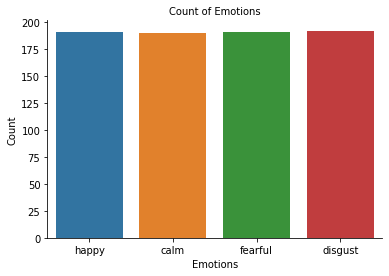

In [7]:
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

In [8]:
print((X_train.shape[0], X_test.shape[0]))

(573, 191)


In [9]:
print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 180


In [10]:
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, 
                      hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [11]:
model.fit(X_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [12]:
predictions = model.predict(X_test)

In [13]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = predictions
df['Actual Labels'] = y_test

df.head(10)

,Predicted Labels,Actual Labels
0,fearful,fearful
1,calm,calm
2,happy,happy
3,happy,happy
4,fearful,fearful
5,happy,disgust
6,disgust,disgust
7,disgust,disgust
8,happy,happy
9,disgust,disgust


In [14]:
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 64.40%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


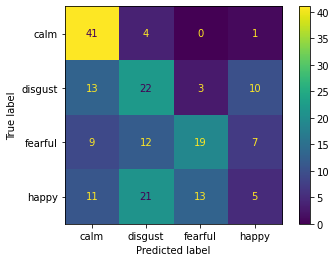

In [15]:
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        calm       0.83      0.63      0.72        46
     disgust       0.70      0.65      0.67        48
     fearful       0.57      0.85      0.68        47
       happy       0.69      0.58      0.63        50

    accuracy                           0.68       191
   macro avg       0.70      0.68      0.68       191
weighted avg       0.70      0.68      0.68       191

